#### NX-414: Brain-like computation and intelligence
##### TA: Alessandro Marin Vargas

# Week 6 - Mini projects (Predicting neural activity)

The objective of the mini project is to:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. Here, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

In [1]:
import sys
sys.path.append('./../')
!{sys.executable} -m pip install gdown h5py

In [2]:
from week5.utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
import gdown
url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
output = "IT_data.h5"
gdown.download(url, output, quiet=False, fuzzy=True)


Downloading...
From (uriginal): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS
From (redirected): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS&confirm=t&uuid=ab0cae12-476f-48cf-8020-c0595f5dc186
To: /home/jupyter/NX414-Project/week5/IT_data.h5
100%|██████████| 384M/384M [00:01<00:00, 229MB/s]  


'IT_data.h5'

### Load the data

In [3]:
path_to_data = '' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)


In [4]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channgels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

The dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channgels (RGB)
The size of the image is 224x224


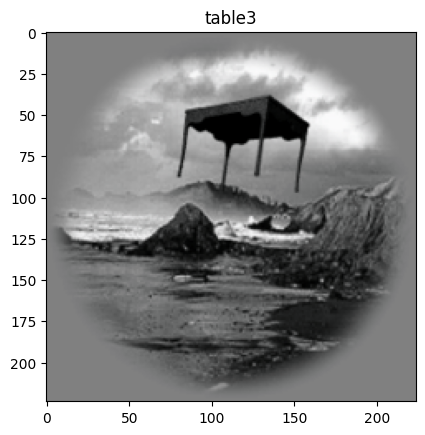

In [5]:
stim_idx = 1

visualize_img(stimulus_train,objects_train,stim_idx)

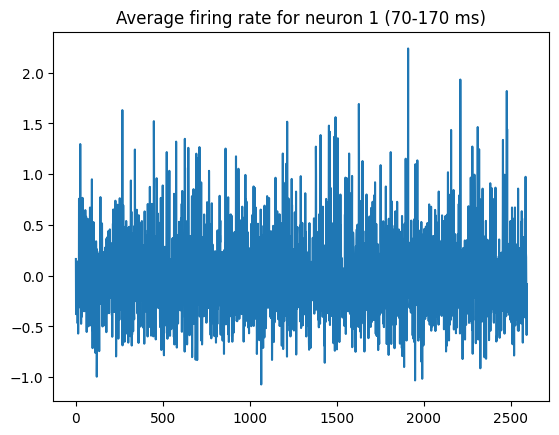

In [6]:
neuron_idx = 1

plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(neuron_idx))
plt.plot(spikes_train[:,neuron_idx])

## Predict the neural activity using a data-driven approach

In the first part of the project, you have predicted the neural activity either from pixels or from the activations of a pre-trained neural network model. Here, your objective is to build and train a shallow convolutional neural network to predict the IT neural activity.

Follow these steps:
- Create the dataloader
- Define the model (Shallow CNN with 2/3 layers)
- Define the loss function (MSE) and the optimizer
- Build the training script and train your model
- Evaluate the predictions of your model. 
- Compare the neural predictions with the ones achieved by the task-trained neural network model. Which one can better predict the neural activity?

Building the data loaders:

In [66]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn

train_dataloader = DataLoader(stimulus_train, batch_size=64, shuffle=True)
test_dataloader = DataLoader(stimulus_test, batch_size=64, shuffle=True)

device = ("cuda" if torch.cuda.is_available() else "cpu")

**Here we implement a shallow CNN, made of two sets of CNN=>Relu=>Maxpool layers followed by two fully connected layers. This model is derived from the famous LeNet model, that is designed to perform classification. In order to adapt it to the multi-regression task that we want it to perform, we simply replaced the final fully connected log-softmax classification layer by a fully connected layer with 168 nodes (since we want to predict the activations of all 168 neurons), along with a linear activation function.**

In [67]:
# import the necessary packages
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch import flatten

from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import ToTensor
from torch.optim import Adam
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import argparse
import torch
import time


class LeNet(Module):
	def __init__(self, numChannels, classes):
		# call the parent constructor
		super(LeNet, self).__init__()
		# initialize first set of CONV => RELU => POOL layers
		self.conv1 = Conv2d(in_channels=numChannels, out_channels=20,
			kernel_size=(5, 5))
		self.relu1 = ReLU()
		self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
		# initialize second set of CONV => RELU => POOL layers
		self.conv2 = Conv2d(in_channels=20, out_channels=50,
			kernel_size=(5, 5))
		self.relu2 = ReLU()
		self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
		# initialize first (and only) set of FC => RELU layers
		self.fc1 = Linear(in_features=140450, out_features=500)
		self.relu3 = ReLU()
		self.fc2 = Linear(in_features=500, out_features=classes)
        
	def forward(self, x):
		# pass the input through our first set of CONV => RELU =>
		# POOL layers
		x = self.conv1(x)
		x = self.relu1(x)
		x = self.maxpool1(x)
		# pass the output from the previous layer through the second
		# set of CONV => RELU => POOL layers
		x = self.conv2(x)
		x = self.relu2(x)
		x = self.maxpool2(x)
		# flatten the output from the previous layer and pass it
		# through our only set of FC => RELU layers
		x = flatten(x, 1)
		x = self.fc1(x)
		x = self.relu3(x)
		# output after the second fc layer
		output=self.fc2(x)
        
		# return the output predictions
		return output
        


We use a MSE loss and SGD optimizer, commonly used for regression tasks:

In [68]:
# Initialize the LeNet model
model = LeNet(numChannels=3,classes=168).to(device)
# initialize our optimizer and loss function
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)


Below is out training script. We display the training and validation losses at each epoch:

In [81]:
# Reload the data just for coherence
stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)

stimulus_train = torch.from_numpy(stimulus_train).type(torch.FloatTensor)
spikes_train=torch.from_numpy(spikes_train).type(torch.FloatTensor)
dataset_train=TensorDataset(stimulus_train,spikes_train)
train_dataloader=DataLoader(dataset_train)

stimulus_val = torch.from_numpy(stimulus_val).type(torch.FloatTensor)
spikes_val=torch.from_numpy(spikes_val).type(torch.FloatTensor)
dataset_val=TensorDataset(stimulus_val,spikes_val)
val_dataloader=DataLoader(dataset_val)

trainSteps = len(train_dataloader.dataset) #BATCH_SIZE
valSteps = len(val_dataloader.dataset) #BATCH_SIZE

EPOCHS=10 #Number of epochs
epoch=1 #Counter of epochs
for e in range(0, EPOCHS):
	# set the model in training mode
	model.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalValLoss = 0
	
	# loop over the training set
	for (x, y) in train_dataloader:
		# send the input to the device
		(x, y) = (x.to(device), y.to(device))
		# perform a forward pass and calculate the training loss
		pred = model(x)
		loss = criterion(pred, y)
		# zero out the gradients, perform the backpropagation step,
		# and update the weights
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
	with torch.no_grad():    
		model.eval()
		# loop over the validation set
		for (x, y) in val_dataloader:
			# send the input to the device
			(x, y) = (x.to(device), y.to(device))
			# make the predictions and calculate the validation loss
			pred = model(x)
			totalValLoss += criterion(pred, y)
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss/trainSteps
	avgValLoss = totalValLoss/valSteps
	print("Epoch {}, Avg training loss={}, Avg validation loss={}".format(epoch,avgTrainLoss,avgValLoss))
	epoch+=1
            
print("Training Complete")
    

Epoch 1, Avg training loss=0.03265189379453659, Avg validation loss=0.1316947042942047
Epoch 2, Avg training loss=0.02848980762064457, Avg validation loss=0.13242816925048828
Epoch 3, Avg training loss=0.027051834389567375, Avg validation loss=0.133796826004982
Epoch 4, Avg training loss=0.025686893612146378, Avg validation loss=0.13131484389305115
Epoch 5, Avg training loss=0.022830026224255562, Avg validation loss=0.13305406272411346
Epoch 6, Avg training loss=0.019928960129618645, Avg validation loss=0.13521483540534973
Epoch 7, Avg training loss=0.017525620758533478, Avg validation loss=0.1345825344324112
Epoch 8, Avg training loss=0.015701185911893845, Avg validation loss=0.13693177700042725
Epoch 9, Avg training loss=0.014195111580193043, Avg validation loss=0.13754260540008545
Epoch 10, Avg training loss=0.012827467173337936, Avg validation loss=0.13840925693511963
Training Complete


**Let's evaluate the model with the previously used metrics (explained variance and correlation):**

In [83]:
stimulus_val=stimulus_val.cuda()
with torch.no_grad():
    pred_val=model(stimulus_val)

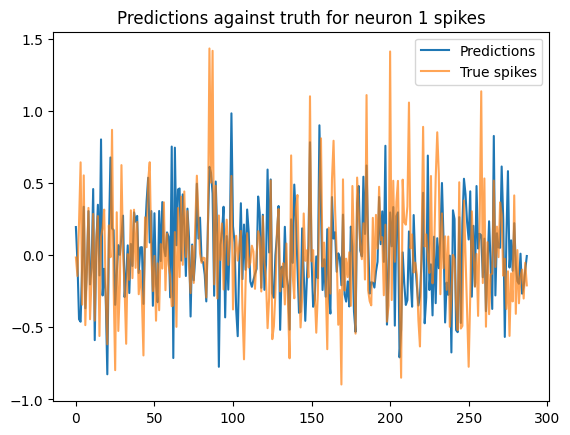

In [107]:
#Example of comparison between truth and predictions for one neuron
plt.plot(pred_val.cpu().detach().numpy()[:,1],label='Predictions')
plt.plot(spikes_val.cpu().numpy()[:,1],label='True spikes',alpha=0.7)
plt.title('Predictions against truth for neuron 1 spikes')
plt.legend()
plt.show()

Even if the picture looks rather good, we need to go back to the metrics we used in week5.ipynb to assess properly the performances of the model. More specifically let's see what are the results in terms of explained variance and correlations. 

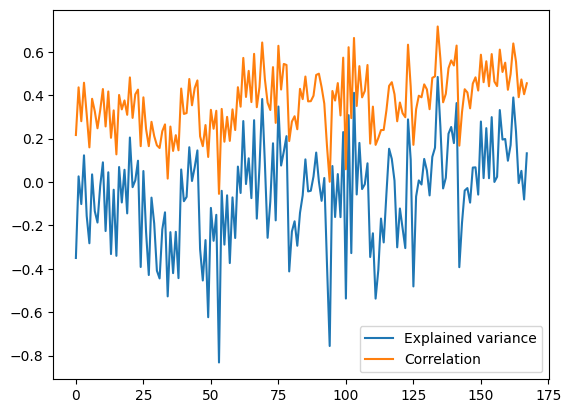

In [106]:
from sklearn.metrics import explained_variance_score

exp_var=[]
corr=[]
for i in range(168):
    exp_var.append(explained_variance_score(spikes_val.cpu().numpy()[:,i],pred_val.cpu().detach().numpy()[:,i]))
    corr.append(np.corrcoef(spikes_val.cpu().numpy()[:,i],pred_val.cpu().detach().numpy()[:,i])[0,1])
plt.plot(exp_var,label='Explained variance')
plt.plot(corr,label='Correlation')
plt.legend()
plt.show()


**One can immediatly notice that these are not excellent results. These are roughly the same performances as we obtained when performing a ridge regression on the principal components of the pixel data.**
**In particular, these results are significantly worse than the ones obtained when performing a regression on the activations of the hidden layers of the ResNet50 model.**  
Even if the fact that we obtain better results with the task-driven approach is not incoherent with the results commonly accepted today (discussed in class, notably from Schrimpf et al. (2018)), the performances of our model in particular are pretty low. We are going to try different improvements in Week7.